In [3]:
import torch
import torch.nn.functional as F
from torch import optim

import yaml
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import cupy as cp


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.preprocessing import quantile_transform, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

from x_transformers import XTransformer, TransformerWrapper, Decoder, Encoder, ViTransformerWrapper

from aptamer_transformer.model import *
from aptamer_transformer.factories_model_loss import *
from aptamer_transformer.data_utils import *
from aptamer_transformer.dataset import *

%load_ext autoreload
%autoreload 2

2024-03-11 21:29:14.891018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 21:29:16.102792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
df = load_df(cfg)
# dfs = read_data_files(cfg)
# counter_set = normalized_counters(dfs)
# enrichment_scores = all_enrichments(counter_set)
# unique_sequences = log_normalize_enrichment_scores(enrichment_scores)

In [143]:
df = log_normed_load_and_preprocess_enrichment_data(cfg)

In [3]:
with open('../data/nupack_strucutre_data/all_mfe.pickle', 'rb') as f:
    mfe = pickle.load(f)
    
energy = {k: v[0].energy for k, v in mfe.items()}
dot_bracket = {k: v[0].structure.dotparensplus() for k, v in mfe.items()}
strucutre_matrix = {k: v[0].structure.structure_matrix() for k, v in mfe.items()}


In [4]:
unique_sequences['energy'] = unique_sequences['Sequence'].map(energy)
unique_sequences['dot_bracket'] = unique_sequences['Sequence'].map(dot_bracket)
unique_sequences['strucutre_matrix'] = unique_sequences['Sequence'].map(strucutre_matrix)

In [5]:
df = unique_sequences.copy()


In [6]:
df

,Sequence,Normalized_Frequency,sum,max,min,count,energy,dot_bracket,strucutre_matrix,Discretized_Frequency
0,AAAAAAAATGGGGGGGGGGGGGGGGGGGGTCTGTTTATTT,0.218865,0.293243,0.071264,0.533216,3,1.000000,........................................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,AAAAAAACGGCATCGCTAGGCATCAGGTCCCATCCGGTTA,0.465646,0.307381,0.289093,0.621446,3,0.919390,....((.(((.......................))).)).,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,AAAAAAATTGGGGGGGGGGGGGGGGGGGGTCTGTTTATTT,0.301842,0.297997,0.166499,0.597775,3,1.000000,........................................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,AAAAACAAACCATACAACCCAGACGGCCCGCTGATTTACA,0.398200,0.303517,0.166499,0.712720,3,0.931937,...................(((.((...))))).......,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,AAAAACGCAGCAAACAAGGACCCACGTACGCCCGCATTAT,0.540360,0.316853,0.278974,0.763822,6,0.954282,....(((.................))).............,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
...,...,...,...,...,...,...,...,...,...,...
513690,TTTTTTTTTTTTTTGGGGGGGGGGGGGGGGGGGGGGTCCC,0.458486,0.309976,0.294501,0.658055,21,0.921781,.............................(((.....))),"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
513691,TTTTTTTTTTTTTTGGGGGGGGGGGGGGGGGGGGGTTTCT,0.513825,0.310141,0.196496,0.843051,3,1.000000,........................................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
513692,TTTTTTTTTTTTTTGGGGGGGGGGGTGGCCGGGGGGTCCC,0.519663,0.314481,0.278974,0.706349,6,0.922903,.....................((.....))(((....))),"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
513693,TTTTTTTTTTTTTTGGGGGGGGGGGTGGGCGGGGGGTCCC,0.442661,0.306064,0.187988,0.735655,3,0.934520,..............................(((....))),"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


array([[<Axes: title={'center': 'Normalized_Frequency'}>]], dtype=object)

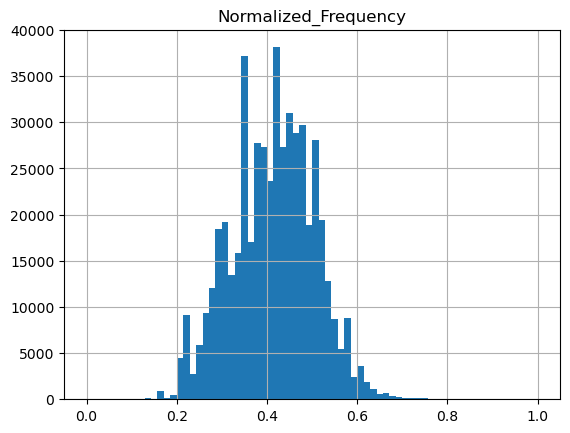

In [13]:
df.hist(column='Normalized_Frequency', bins=70)

array([[<Axes: title={'center': 'Discretized_Frequency'}>]], dtype=object)

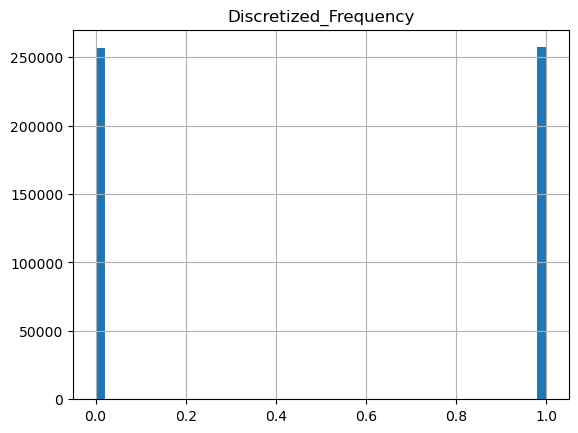

: 

In [15]:
df.hist(column='Discretized_Frequency', bins=50)

In [18]:
def is_nucleotide_dominant(sequence):
    for nucleotide in ['A', 'T', 'C', 'G']:
        if sequence.count(nucleotide) / len(sequence) > 0.66:
            return True
    return False

def contains_poly_n(sequence):
    for nucleotide in ['A', 'T', 'C', 'G']:
        if nucleotide * 10 in sequence:
            return True
    return False

# Apply the function to filter out sequences
df_filtered = df[~df['Sequence'].apply(is_nucleotide_dominant)]
# df_filtered = df_filtered[~df_filtered['Sequence'].apply(contains_poly_n)]
df_filtered = df_filtered[df_filtered['count'] > 1]

scaler = MinMaxScaler()

columns_to_scale = ['mean', 'min', 'max', 'sum', 'energy']

# Apply scaler to each column separately
for col in columns_to_scale:
    df_filtered[col] = scaler.fit_transform(df_filtered[[col]])

df_filtered = df_filtered.dropna(subset=columns_to_scale)


df_filtered.sort_values(by='mean', ascending=False)

,Sequence,mean,sum,max,min,count,energy,dot_bracket,strucutre_matrix
560539,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT,1.000000,1.000000,1.000000,0.736840,66,0.911054,.(((.............)))....................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
175157,CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG,0.994638,0.878780,0.917585,0.756909,55,0.930711,.(((.(..........).)))((....))............,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1086387,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,0.981617,0.865104,0.810912,0.839269,55,0.820253,.(.((.....)).)(((..........)))..........,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
57001,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT,0.971929,0.755209,0.830588,0.843051,45,0.950861,......................(.((.....)).).....,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1155409,TGGGGGGGAGGGTAGGGTATGGGGTCGTACAGTGGGTTTCG,0.967657,0.850441,0.808411,0.804341,55,0.967572,...........(((.(.........).)))...........,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...
1105430,TGAGGGGCGGGGTGGTGGGGGGTTTTGTCTGCCACAAGTG,0.087888,0.285739,0.073459,0.376974,3,0.879711,..............((((.............)))).....,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
965299,GTCATACACACGCTCACGCACCCGGCGCAGGGTTGAGCGA,0.063676,0.195882,0.069590,0.149619,15,0.630090,..........((((((...((((......)))))))))).,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
19559,ACAGGCGCCGCTGGTCGACGCAGACCCGCCTAAGTTGTTA,0.061320,0.232295,0.062711,0.186865,10,0.721737,..(((((.....((((......))))))))).........,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1143027,TGGGCCATGGAATCGGTACGCACCGGTCGCAGGTTAACGA,0.055909,0.193657,0.076944,0.172180,15,0.821094,......((...))((((....))))..((........)).,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


array([[<Axes: title={'center': 'mean'}>]], dtype=object)

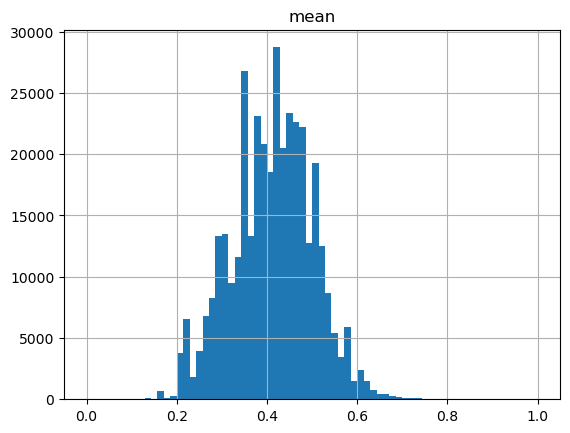

In [39]:
df_filtered.hist(column='mean', bins=70)

In [10]:
has_nan = df_filtered.isna().values.any()
print("Are there any NaN values in the DataFrame?", has_nan)

nan_counts = df_filtered.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)


Are there any NaN values in the DataFrame? False
Number of NaN values in each column:
 Sequence            0
mean                0
sum                 0
max                 0
min                 0
count               0
energy              0
dot_bracket         0
strucutre_matrix    0
dtype: int64


In [ ]:
X = df_filtered['mean'].values.reshape(-1, 1)
y = df_filtered['energy'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regression": SVR()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R2: {r2}")

Linear Regression - MSE: 0.018463567046175692, R2: 0.06550173132459414
Ridge Regression - MSE: 0.01846357030123839, R2: 0.0655015665757972
Lasso Regression - MSE: 0.01975778506867407, R2: -2.64809941064037e-06
Random Forest - MSE: 0.017313955470146514, R2: 0.1236871309692954


In [6]:
df_filtered = df.copy()

scaler = MinMaxScaler()

columns_to_scale = ['mean', 'min', 'max', 'sum', 'energy']

# Apply scaler to each column separately
for col in columns_to_scale:
    df_filtered[col] = scaler.fit_transform(df_filtered[[col]])

df_filtered = df_filtered.dropna(subset=columns_to_scale)

In [97]:
d_model = 8

In [100]:
tokenizer = AutoTokenizer.from_pretrained(cfg['seq_tokenizer_path'])
tokenized_data = tokenizer(df_filtered['Sequence'].tolist(), padding=True, return_tensors="pt")
tokenized_seqs = tokenized_data.input_ids
seq_attn_mask = tokenized_data.attention_mask

In [115]:
seq_attn_mask.shape

torch.Size([513695, 42])

In [101]:
embeddings = nn.Embedding(tokenizer.vocab_size, d_model, padding_idx=tokenizer.pad_token_id)

seqs_embedded = embeddings(tokenized_seqs)
seqs_embedded.shape

torch.Size([513695, 42, 8])

In [96]:
struc_tokenizer = AutoTokenizer.from_pretrained(cfg['dot_bracket_tokenizer_path'])
tokenized_dot_bracket_data = tokenizer(df_filtered['dot_bracket'].tolist(), padding=True, return_tensors="pt")
tokenized_dot_bracket = tokenized_dot_bracket_data.input_ids
dot_bracket_attn_mask = tokenized_dot_bracket_data.attention_mask

In [116]:
dot_bracket_attn_mask.shape

torch.Size([513695, 42])

In [102]:
dot_bracket_embeddings = nn.Embedding(struc_tokenizer.vocab_size, d_model, padding_idx=struc_tokenizer.pad_token_id)

dot_bracket_embedded = dot_bracket_embeddings(tokenized_dot_bracket)
dot_bracket_embedded.shape

torch.Size([513695, 42, 8])

In [113]:
energy = torch.Tensor(df_filtered['energy'].values.reshape(-1, 1)).unsqueeze(-1)
energy_attn = torch.ones(energy.shape[0], 1, dtype=torch.long)

energy_linear = nn.Linear(1, d_model)

energy_embedded = energy_linear(energy)

energy_attn.shape

torch.Size([513695, 1])

In [125]:
max_matrix_size = max(df_filtered['strucutre_matrix'].apply(lambda x: len(x)))
padded_structure_matrix = df_filtered['strucutre_matrix'].apply(
    lambda matrix: np.pad(matrix, (0, max_matrix_size - len(matrix)), mode='constant')
)

In [128]:
structure_matrix = torch.Tensor(padded_structure_matrix)
structure_matrix.shape

torch.Size([513695, 41, 41])

In [120]:
combined_features = torch.concat([seqs_embedded, dot_bracket_embedded, energy_embedded], dim=1)
combined_attn_mask = torch.concat([seq_attn_mask, dot_bracket_attn_mask, energy_attn], dim=1)



In [83]:
def tokenize_sequence(seq):
    return list(seq)

def tokenize_sequence(seq, max_length, padding_char='N'):
    seq += padding_char * (max_length - len(seq))  # Pad the sequence
    return list(seq)


max_seq_length = max(df_filtered['Sequence'].apply(len))
max_dot_bracket_length = max(df_filtered['dot_bracket'].apply(len))

sequence_tokenized = np.array([tokenize_sequence(seq, max_seq_length) for seq in df_filtered['Sequence']])
dot_bracket_tokenized = np.array([tokenize_sequence(seq, max_dot_bracket_length, '.') for seq in df_filtered['dot_bracket']])

# One-hot encoding the tokenized sequences
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
sequence_encoded = onehot_encoder.fit_transform(sequence_tokenized)
dot_bracket_encoded = onehot_encoder.fit_transform(dot_bracket_tokenized)

# Flatten the encoded arrays
sequence_flattened = sequence_encoded.reshape(df_filtered.shape[0], -1)
dot_bracket_flattened = dot_bracket_encoded.reshape(df_filtered.shape[0], -1)

# Feature 2 - energy
energy = df_filtered['energy'].values.reshape(-1, 1)

# Feature 4 - structure_matrix
max_matrix_size = max(df_filtered['strucutre_matrix'].apply(lambda x: len(x)))
padded_structure_matrix = df_filtered['strucutre_matrix'].apply(
    lambda matrix: np.pad(matrix, (0, max_matrix_size - len(matrix)), mode='constant')
)
structure_matrix = np.array(padded_structure_matrix.tolist())
flattened_structure_matrix = np.array([matrix.flatten() for matrix in structure_matrix])

# Concatenate all features
X = np.hstack((sequence_flattened, dot_bracket_flattened, energy, flattened_structure_matrix))


# Target variable
y = df_filtered['Normalized_Frequency'].values

# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)

In [75]:
sequence_flattened.shape, dot_bracket_flattened.shape, energy.shape, flattened_structure_matrix.shape, X.shape, y.shape

((513695, 175),
 (513695, 114),
 (513695, 1),
 (513695, 1681),
 (513695, 1971),
 (513695,))

In [56]:
y_train_gpu

array([ 0.237831  ,  0.64329611,  0.33786096, ..., -1.15670226,
        0.0103423 ,  0.22809622])

In [ ]:
# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [5, 10, 20],
    'alpha': [5, 10, 15],
    'n_estimators': [10, 50, 100]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='gpu')

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
search_space = {
    'max_depth': Integer(1, 20),
    'min_child_weight': Integer(0, 20),
    'gamma': Real(0.01, 10, 'log-uniform'),  # Adjusted lower bound
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.01, 1.0),
    }


# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='gpu')

# Initialize the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_space,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=32,
    n_jobs=-1,
    return_train_score=True,
    random_state=42,
    verbose=5
)

# X_train_numpy = X_train_gpu.get() if isinstance(X_train_gpu, cp.ndarray) else X_train_gpu
# y_train_numpy = y_train_gpu.get() if isinstance(y_train_gpu, cp.ndarray) else y_train_gpu

bayes_cv.fit(X_train, y_train)
# Perform the search

# Print the best parameters and best score
print("Best parameters found: ", bayes_cv.best_params_)
print("Best RMSE found: ", np.sqrt(-bayes_cv.best_score_))

# Evaluate the model with the best parameters
best_model = bayes_cv.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on Test Set: %f" % (rmse))

In [84]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',
    colsample_bytree=0.7,  # Updated
    learning_rate=0.1,     # Updated
    max_depth=10,          # Updated
    alpha=5,               # Updated
    n_estimators=100,      # Updated
    tree_method='hist',    # Assuming you're still using GPU acceleration
    device='gpu'           # Assuming you're still using GPU acceleration
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared: %f" % r2)


R-squared: 0.492642


In [39]:
df_filtered = df_filtered.rename(columns={'mean': 'Normalized_Frequency'})
df_filtered = df_filtered.reset_index(drop=True)

In [9]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

device = torch.device("cpu")  
cfg.update({
    'device': device,
})

dna_dataset = load_dataset(cfg)

model = get_model(cfg)



In [14]:
model

SeqStructXAptamerBertClassifier(
  (aptamer_bert_encoding): SeqStructXAptamerBert(
    (x_transformer_encoder): XTransformerEncoder(
      (x_transformer_encoder): TransformerWrapper(
        (token_emb): TokenEmbedding(
          (emb): Embedding(12, 120)
        )
        (post_emb_norm): Identity()
        (emb_dropout): Dropout(p=0.4, inplace=False)
        (project_emb): Identity()
        (attn_layers): Encoder(
          (layers): ModuleList(
            (0): ModuleList(
              (0): ModuleList(
                (0): SimpleRMSNorm()
                (1-2): 2 x None
              )
              (1): Attention(
                (to_q): Linear(in_features=120, out_features=128, bias=False)
                (to_k): Linear(in_features=120, out_features=128, bias=False)
                (to_v): Linear(in_features=120, out_features=128, bias=False)
                (attend): Attend(
                  (attn_dropout): Dropout(p=0.4, inplace=False)
                )
                (to_o

In [57]:
cfg['num_tokens'] = dna_dataset.tokenizer.vocab_size
cfg['max_seq_len'] = dna_dataset.tokenizer.model_max_length



In [65]:
dna_dataset.X[:10].unsqueeze(-1).shape

torch.Size([10, 1971, 1])

In [69]:
y = model(dna_dataset.X[:10])

In [73]:
dna_dataset.X.shape

torch.Size([513695, 1971, 1])

In [70]:
save_data_set_as_pickle(dna_dataset, cfg)

PicklingError: Can't pickle <class 'aptamer_transformer.dataset.XGBoostDataset'>: it's not the same object as aptamer_transformer.dataset.XGBoostDataset

In [11]:
importance = model.feature_importances_

importance

array([0.00117157, 0.00126148, 0.00163361, ..., 0.        , 0.        ,
       0.0004682 ], dtype=float32)

In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model


# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % rmse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE: %f" % mae)


# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: %f" % mse)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE: %f%%" % mape)

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)
print("Explained Variance Score: %f" % explained_variance)

# Median Absolute Error
median_ae = median_absolute_error(y_test, y_pred)
print("Median Absolute Error: %f" % median_ae)


# feature_names = ["Sequence"] + ["dot_bracket"] + ['energy'] + ['structure_matrix']
# # Feature Importance
# importance = model.feature_importances_
# # Assuming you have feature names in a list 'feature_names'
# for i, v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (feature_names[i], v))

# # Cross-Validation Scores
# cv_scores = cross_val_score(model, X, y, cv=5)
# print("Cross-Validation Scores: ", cv_scores)

# # Learning Curves
# train_sizes, train_scores, validation_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 5))
# plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
# plt.plot(train_sizes, np.mean(validation_scores, axis=1), 'o-', color="g", label="Cross-validation score")
# plt.title("Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("Score")
# plt.legend(loc="best")
# plt.show()

RMSE: 0.093049
MAE: 0.070006
MSE: 0.008658
MAPE: inf%
Explained Variance Score: 0.237908
Median Absolute Error: 0.052792


/glade/derecho/scratch/mlsample/tmp/ipykernel_15438/2329638207.py:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [91]:
importance

array([0.        , 0.00258813, 0.00136215, ..., 0.        , 0.        ,
       0.00183746], dtype=float32)

In [181]:
np.array(df_filtered['energy']).shape

(376828,)

In [180]:
x = np.array(df_filtered['mean'])[::500]
y = np.array(df_filtered['energy'])[::500]

reg = np.polyfit(x, y, 1)

z = np.poly1d(reg)


Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

In [178]:
z

poly1d([ 3.27167726e+06, -1.43817845e+07,  2.78642752e+07, -3.12970935e+07,
        2.25377900e+07, -1.08569844e+07,  3.53785929e+06, -7.68941268e+05,
        1.06552808e+05, -8.49288582e+03,  2.96431392e+02])

KeyboardInterrupt: 

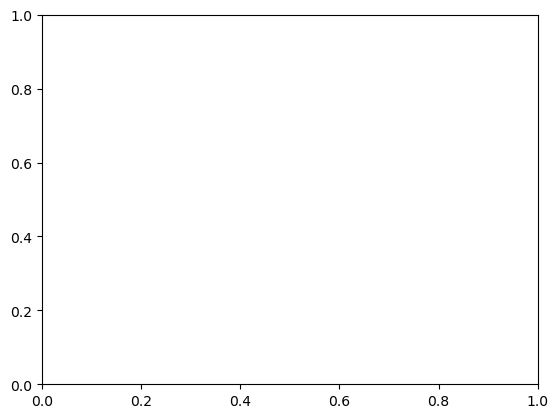

In [33]:
plt.plot(X_train, y_train, 'o')

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

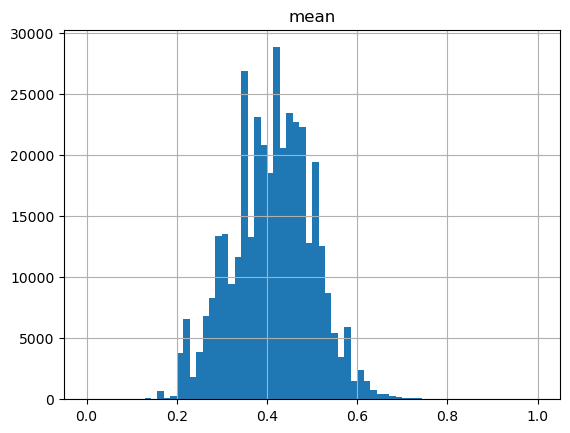

In [156]:
df_filtered.hist(column='mean', bins=70)

<BarContainer object of 4 artists>

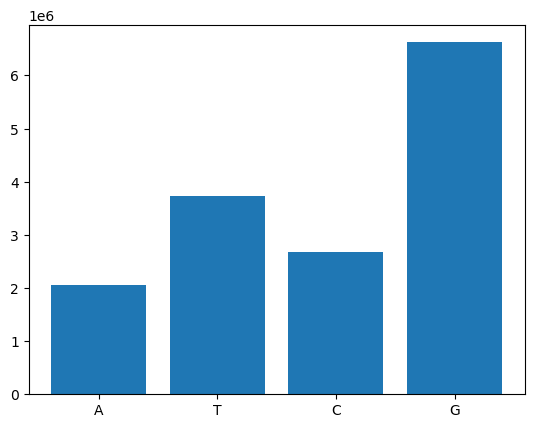

In [142]:
import matplotlib.pyplot as plt
nucleotide_counts = {'A': 0, 'T': 0, 'C': 0, 'G': 0}

# Function to count nucleotides in a sequence
def count_nucleotides(sequence):
    for nucleotide in nucleotide_counts.keys():
        nucleotide_counts[nucleotide] += sequence.count(nucleotide)

# Apply the function to each sequence
df_filtered['Sequence'].apply(count_nucleotides)

# Now nucleotide_counts contains the total count for each nucleotide
plt.bar(nucleotide_counts.keys(), nucleotide_counts.values())


In [4]:
with open('../data/nupack_strucutre_data/mfe.pickle', 'rb') as f:
    mfe = pickle.load(f)

In [6]:
# Initialize the model and optimizer here as you did during training
device = torch.device("cuda:0")  
cfg.update({
    'device': device,
})

model = get_model(cfg).to(device)
# optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

# # Load the checkpoint
# checkpoint = torch.load(cfg['checkpoint_path'])  # Replace X with the epoch number

# # Restore the model and optimizer states
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Move the model to evaluation mode if you are doing inference
# model.eval()


In [39]:
logits, embed, tgt = model(df.Sequence[:2].tolist(), df.Sequence[:2].tolist())

embed[:,0,:].shape

torch.Size([2, 512])

In [ ]:
df = load_and_preprocess_enrichment_data(cfg)


In [3]:
df = pd.read_hdf('../data/saved_h5/dna_dataset_classification.h5', 'df')

In [4]:
dna_dataset = DNAEncoderDataSet(df, cfg)

In [5]:
import pickle

In [6]:
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(dna_dataset, f, pickle.HIGHEST_PROTOCOL)

In [7]:
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

In [13]:
mask = torch.full([max_seq_len, max_seq_len], float('-inf'))
mask = torch.triu(mask, diagonal=1)

mask

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:

N = 20  # Replace with your value of N

# Regular expression pattern to match more than N consecutive 'G's
pattern = f'C{{{N},}}'

# Filter sequences with more than N consecutive 'G's
sequences_with_consecutive_Gs = df[df['Sequence'].str.contains(pattern)]

print(len(sequences_with_consecutive_Gs))

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling

tokenizer = Tokenizer(BPE(unk_token="N"), )
tokenizer.pre_tokenizer = Whitespace()
tokenizer.mask_token = "[MASK]"
tokenizer.cls_token = "[CLS]"
tokenizer.pad_token = "[PAD]"
tokenizer.unknown_token = "N"
tokenizer.model_max_length = 42
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]")
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A",
    special_tokens=[("[PAD]",0), ("N", 1), ("[CLS]", 2), ("[MASK]", 3)]
)

trainer = BpeTrainer(
    vocab_size=8,
    special_tokens=["[PAD]", "N", "[CLS]", "[MASK]"],
)

temp_df = df.Sequence.apply(lambda x:" ".join(x))
tokenizer.train_from_iterator(temp_df.values, trainer=trainer)

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer, model_max_length=42, cls_token="[CLS]", unk_token="N", pad_token="[PAD]", mask_token="[MASK]", return_special_tokens_mask=1)


In [ ]:
fast_tokenizer.save_pretrained('../data/AptamerBERT_tokenizer')

In [11]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
tokenizer = AutoTokenizer.from_pretrained('../data/AptamerBERT_tokenizer')
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
tokenizer

PreTrainedTokenizerFast(name_or_path='../data/AptamerBERT_tokenizer', vocab_size=8, model_max_length=42, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': 'N', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("N", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
tokenizer.model_max_length

In [13]:
temp_df = df.Sequence.apply(lambda x:" ".join(x))

batched_data = temp_df.values.tolist()[:1000]
tokenized_batch = tokenizer(batched_data, padding=True, )

masked_data = data_collator(tokenized_batch.input_ids)


In [18]:
~torch.Tensor(tokenized_batch['attention_mask']).bool()

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        ...,
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg['device'] = device

model = x_transformer_encoder= TransformerWrapper(
    num_tokens = 8,
    max_seq_len = 42,
    num_memory_tokens = cfg['num_memory_tokens'],
    l2norm_embed = cfg['l2norm_embed'],
    attn_layers = Encoder(
        dim = cfg['d_model'],
        depth = cfg['num_layers'],
        heads = cfg['nhead'],
        layer_dropout = cfg['dropout_rate'],   # stochastic depth - dropout entire layer
        attn_dropout = cfg['dropout_rate'],    # dropout post-attention
        ff_dropout = cfg['dropout_rate'],       # feedforward dropout,
        attn_flash = cfg['attn_flash'],
        attn_num_mem_kv = cfg['attn_num_mem_kv'],
        use_scalenorm = cfg['use_scalenorm'],
        use_simple_rmsnorm = cfg['use_simple_rmsnorm'],
        ff_glu = cfg['ff_glu'],
        ff_swish = cfg['ff_swish'],
        ff_no_bias = cfg['ff_no_bias'],
        attn_talking_heads = cfg['attn_talking_heads']
    )
).to(device)



src = masked_data['input_ids'].to(device)
src_mask = torch.Tensor(tokenized_batch.attention_mask).bool().to(device)

trg = masked_data['labels'].to(device)


out = model(src, mask=src_mask)

In [ ]:
F.cross_entropy(out.movedim(2,1), trg)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg['device'] = device

model = XTransformer(
    dim = cfg['d_model'],
    enc_num_tokens = 8,
    enc_depth = cfg['num_layers'],
    enc_heads = 8,
    enc_max_seq_len = 42,
    dec_num_tokens = 8,
    dec_depth = cfg['num_layers'],
    dec_heads = 8,
    dec_max_seq_len = 42,
    tie_token_emb = True      # tie embeddings of encoder and decoder
).to(device)



src = masked_data['input_ids'].to(device)
src_mask = torch.Tensor(tokenized_batch.attention_mask).bool().to(device)

trg = torch.Tensor(tokenized_batch.input_ids).long().to(device)


out = model(src, trg, mask=src_mask)

out

In [ ]:
df.hist(column='Normalized_Frequency', bins=100)